In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time 
from IPython import display
from PIL import Image
import cv2

## 1. Poisson equation

### a) Numerical solution - pretty straight forward, but I experienced some problems with indice synchronization (resolved). 

In [49]:
def animate(array, dim):
    for heat_map in array:
        display.clear_output(wait=True)
        plt.imshow(heat_map.reshape((dim, dim)).T)
        plt.show()

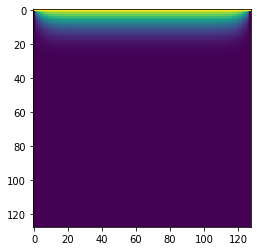

In [50]:
heat = np.loadtxt("heat.txt")
dim = np.sqrt(heat.shape[1])
animate(heat, dim.astype('int'))

### b) Analytical solution for comparison (probably I f\*cked up with initial conditions and get the picture upside down). Also it is much more "bright" (hot) becaise of difference in dimensions - if you will try cuda program for lesser N (32 instead of 128) you will get something similar. But numerical solution is for sure OK.

Let $T(x, y) = X(x)Y(y) \Rightarrow X''Y + Y''X = 0 \Rightarrow X'' + \lambda X = Y'' - \lambda Y = 0$

Solving 2 separated equations and going towards Fourier method, we will get $X_n = A_n\sin{\mu_n x} + B_n\cos{\mu_n x}, Y_n = C_n e^{\mu_n y} + D_n e^{-\mu_n y}$ , where $\mu_n = \pi n$. From this point we should estimate constants and plug in everything into $T = \sum\limits_{n = 0}^{\infty}{X_n Y_n}$.

In [51]:
a = 128
X = np.linspace(0, 1 - 1/a, a)
Y = np.linspace(0, 1 - 1/a, a)

In [52]:
T = np.zeros((a, a))
for i, y in enumerate(X):
    for j, x in enumerate(Y):
        for n in range(1, 50):
            T[i, j] += np.sin(np.pi * n * x) * np.sinh(np.pi * n * y) * (2/np.sinh(np.pi * n) * (1 - (-1)**(n)) / np.pi / n)

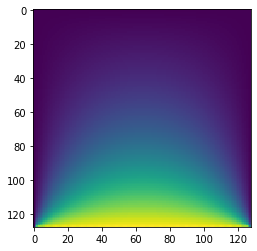

In [54]:
plt.imshow(T)

References (theory, coding):
- http://people.eecs.berkeley.edu/~demmel/cs267/lecture24/lecture24.html
- https://github.com/griera/CUDA-Heat-Equation/blob/master/heatCUDA.cu

## 2. Histogram

#### Works fine, but I think result couls be more precise if one will use different block size (I think should be bigger - 256, 512, ...). Also I did not try to understand how cv2 histogram converter works, maybe it fails and code is 100% ok. 

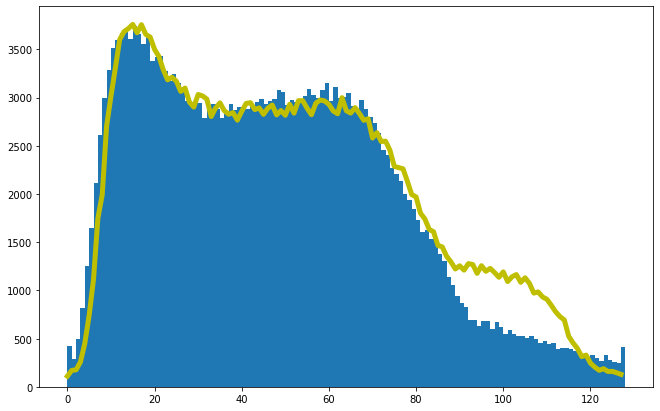

In [62]:
hist = np.loadtxt("Hist.txt")
img = cv2.imread('fractal.jpg', 0)
plt.figure(figsize=(11, 7))
plt.hist(img.ravel(), 128, [0,128])
plt.plot(np.arange(0, 128), hist, lw = 5, color = 'y')
plt.show()

### source for normal histogram for comparison:
- https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_begins/py_histogram_begins.html

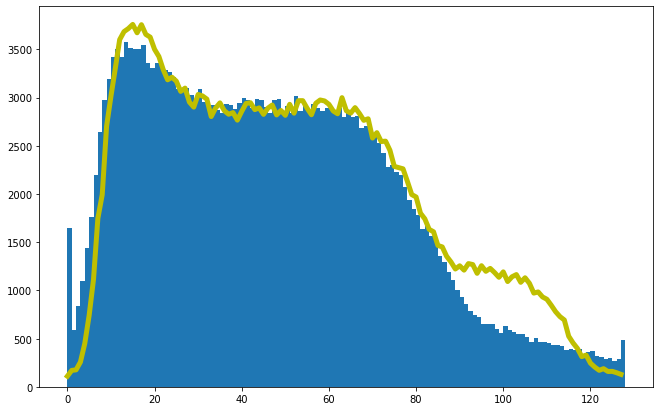

In [58]:
# grayscaled (bad idea, actually):

img = Image.open('fractal.jpg').convert('L')
img.save('greyscale.jpg')
hist = np.loadtxt("Hist.txt")
img = cv2.imread('greyscale.jpg', 0)
plt.figure(figsize=(11, 7))
plt.hist(img.ravel(), 128, [0,128])
plt.plot(np.arange(0, 128), hist, lw = 5, color = 'y')
plt.show()

## 3. Filtering

In [4]:
img = Image.open('fractal.jpg')

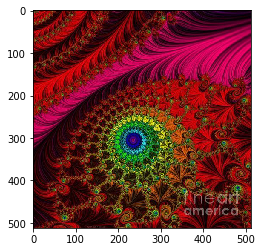

In [5]:
plt.imshow(img)

#### a. Kernels

This is simple box filtering (https://en.wikipedia.org/wiki/Box_blur) , for a fractal, that rich in details ,difference is quite significant, but the best indicator - the watermark actually.

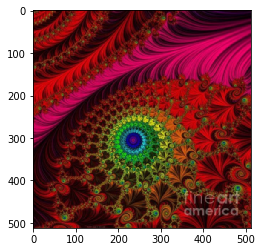

In [2]:
img = Image.open('fractal_box.png')
plt.imshow(img)

Gaussian blur for kernel 5 working just slightly better than box filter, but for significant difference one should implement it with bigger kernel (up to 9). So overall probably my kernel choice was unfortunate and poor(

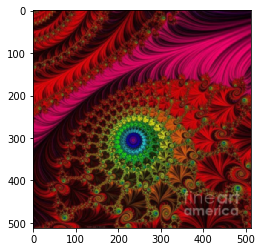

In [3]:
img = Image.open('fractal_gaussian.png')
plt.imshow(img)

#### b. Median (implementation - mix of histogram code and wikipedia pseudocode realization of wikipedia article + boundary consideration - this is basically as in poisson task)

I do not know what of this two could be considered as more cartoonish, but these are representations of 2 different stencil size. Also I noticed that jpg saving does not work for some reason, but does not through an error or warning as well. So I converted it to png instead.

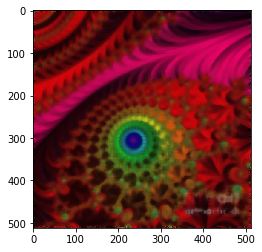

In [7]:
img2 = Image.open('fractal_median.png')
plt.imshow(img2)

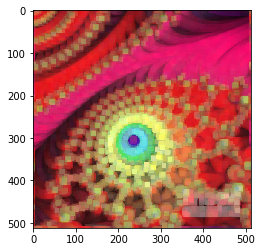

In [8]:
img3 = Image.open('fractal_median_cart.png')
plt.imshow(img3)